### Import Libraries

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, TensorDataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
#!pip install git+https://github.com/aleju/imgaug
import random
import pickle

### Model and necesarry classes

In [ ]:
c = 16
h1 = 4
w1 = 4
ch = 3
h = 4
w = 4
class Net1(torch.nn.Module):
  def __init__ (self):
    super(Net1,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()
    nn.init.normal_(self.conv1.weight)
    nn.init.normal_(self.conv2.weight)
    nn.init.normal_(self.conv3.weight)
    nn.init.normal_(self.conv4.weight)
    nn.init.normal_(self.fc1.weight)
    nn.init.normal_(self.fc2.weight)
    nn.init.normal_(self.downsample1.weight)
    nn.init.normal_(self.downsample2.weight)
    nn.init.normal_(self.downsample3.weight)
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

    # Random initialization
  def initialize_weight(self):
    nn.init.normal_(self.conv1.weight)
    nn.init.normal_(self.conv2.weight)
    nn.init.normal_(self.conv3.weight)
    nn.init.normal_(self.fc1.weight)
    nn.init.normal_(self.fc2.weight)

  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x



class Net2(torch.nn.Module):
  def __init__ (self):
    super(Net2,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h1*w1, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.xavier_uniform_(self.conv1.weight)
    nn.init.xavier_uniform_(self.conv2.weight)
    nn.init.xavier_uniform_(self.conv3.weight)
    nn.init.xavier_uniform_(self.conv4.weight)
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.xavier_uniform_(self.downsample1.weight)
    nn.init.xavier_uniform_(self.downsample2.weight)
    nn.init.xavier_uniform_(self.downsample3.weight)
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

    # Xavier initialization
  def initialize_weight(self):
    nn.init.xavier_uniform_(self.conv1.weight)
    nn.init.xavier_uniform_(self.conv2.weight)
    nn.init.xavier_uniform_(self.conv3.weight)
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h1*w1)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net3(torch.nn.Module):
  def __init__ (self):
    super(Net3,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h1*w1, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv4.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

    # He initialization
  def initialize_weight(self):
    nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')


  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
   # x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h1*w1)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net4(torch.nn.Module):
  def __init__ (self):
    super(Net4,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.kaiming_uniform_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.conv4.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.downsample1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.downsample2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.downsample3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

    # Lecun Initialization
  def initialize_weight(self):
    nn.init.kaiming_uniform_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')


  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net5(torch.nn.Module):
  def __init__ (self):
    super(Net5,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.normal_(self.conv1.weight)
    nn.init.normal_(self.conv2.weight)
    nn.init.normal_(self.conv3.weight)
    nn.init.normal_(self.conv4.weight)
    nn.init.normal_(self.fc1.weight)
    nn.init.normal_(self.fc2.weight)
    nn.init.normal_(self.downsample1.weight)
    nn.init.normal_(self.downsample2.weight)
    nn.init.normal_(self.downsample3.weight)
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
     # Random initialization
  def initialize_weight(self):
    nn.init.normal_(self.conv1.weight)
    nn.init.normal_(self.conv2.weight)
    nn.init.normal_(self.conv3.weight)
    nn.init.normal_(self.fc1.weight)
    nn.init.normal_(self.fc2.weight)

  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net6(torch.nn.Module):
  def __init__ (self):
    super(Net6,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.orthogonal_(self.conv1.weight)
    nn.init.orthogonal_(self.conv2.weight)
    nn.init.orthogonal_(self.conv3.weight)
    nn.init.orthogonal_(self.conv4.weight)
    nn.init.orthogonal_(self.fc1.weight)
    nn.init.orthogonal_(self.fc2.weight)
    nn.init.orthogonal_(self.downsample1.weight)
    nn.init.orthogonal_(self.downsample2.weight)
    nn.init.orthogonal_(self.downsample3.weight)
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
   # Orthogonal initialization
  def initialize_weight(self):
    nn.init.orthogonal_(self.conv1.weight)
    nn.init.orthogonal_(self.conv2.weight)
    nn.init.orthogonal_(self.conv3.weight)
    nn.init.orthogonal_(self.fc1.weight)
    nn.init.orthogonal_(self.fc2.weight)


  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net7(torch.nn.Module):
  def __init__ (self):
    super(Net7,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h1*w1, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv4.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
      # He initialization
  def initialize_weight(self):
    nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')


  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h1*w1)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net8(torch.nn.Module):
  def __init__ (self):
    super(Net8,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv4.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.downsample3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

      # He initialization
  def initialize_weight(self):
    nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')

  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net9(torch.nn.Module):
  def __init__ (self):
    super(Net9,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.constant_(self.conv1.weight, 0.01)
    nn.init.constant_(self.conv2.weight, 0.01)
    nn.init.constant_(self.conv3.weight, 0.01)
    nn.init.constant_(self.conv4.weight, 0.01)
    nn.init.constant_(self.fc1.weight, 0.01)
    nn.init.constant_(self.fc2.weight, 0.01)
    nn.init.constant_(self.downsample1.weight, 0.01)
    nn.init.constant_(self.downsample2.weight, 0.01)
    nn.init.constant_(self.downsample3.weight, 0.01)
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

     # Constant Initialization
  def initialize_weight(self):
    nn.init.constant_(self.conv1.weight, 0.01)
    nn.init.constant_(self.conv2.weight, 0.01)
    nn.init.constant_(self.conv3.weight, 0.01)
    nn.init.constant_(self.fc1.weight, 0.01)
    nn.init.constant_(self.fc2.weight, 0.01)

  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

class Net10(torch.nn.Module):
  def __init__ (self):
    super(Net10,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=ch, out_channels=32, kernel_size=3, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same')
    self.bn4 = nn.BatchNorm2d(16)
    self.pool4 = nn.MaxPool2d(kernel_size = 2)

    self.downsample1 = nn.Conv2d(ch, 64, kernel_size=1, stride=2, bias=False)

    self.downsample2 = nn.Conv2d(64, 16, kernel_size=1, stride=2, bias=False)
    self.downsample3 = nn.Conv2d(ch, 16, kernel_size=1, stride=4, bias=False)

    self.fc1 = nn.Linear(in_features=c*h*w, out_features=128)
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

    nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.conv4.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.downsample1.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.downsample2.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.downsample3.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.conv3.bias)
    nn.init.zeros_(self.conv4.bias)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

      # Glorot initialization
  def initialize_weight(self):
    nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))

  def forward(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    residual1 = self.downsample1(residual)
    x += residual1
    residual1 = x
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)

    #x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)

    residual1 = self.downsample2(residual1)
    residual2 = self.downsample3(residual)
    x += residual1+residual2
    x = self.relu(x)
    x = self.pool4(x)
    x = x.view(-1, c*h*w)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

class Classifier(torch.nn.Module):
  def __init__ (self):
    super(Classifier,self).__init__()
    self.fc1 = nn.Linear(in_features=40, out_features=256)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(in_features=256, out_features=10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x



class MyEnsemble(nn.Module):

    def __init__(self, model1, model2, model3, model4,model5, model6, model7, model8, model9, model10):
        super(MyEnsemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.model4 = model4
        self.model5 = model5
        self.model6 = model6
        self.model7 = model7
        self.model8 = model8
        self.model9 = model9
        self.model10 = model10
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(100, 10)
        self.classifier1 = nn.Linear(100, 10)

        self.a = nn.Softmax(dim=1)
    def init_weight(self):
      self.model1 = self.model1.initialize_weight()
      self.model2 = self.model2.initialize_weight()
      self.model3 = self.model3.initialize_weight()
      self.model4 = self.model4.initialize_weight()
      self.model5 = self.model5.initialize_weight()
      self.model6 = self.model6.initialize_weight()
      self.model7 = self.model7.initialize_weight()
      self.model8 = self.model8.initialize_weight()
      self.model9 = self.model9.initialize_weight()
      self.model10 = self.model10.initialize_weight()

    def forward(self, x):
        batch_size,_,_,_ = x.shape
        out1 = (self.model1(x.clone()))#.view(-1)
        out2 = (self.model2(x.clone()))#.view(-1)
        out3 = (self.model3(x.clone()))#.view(-1)
        out4 = (self.model4(x.clone()))#.view(-1)
        out5 = (self.model5(x.clone()))#.view(-1)
        out6 = (self.model6(x.clone()))#.view(-1)
        out7 = (self.model7(x.clone()))#.view(-1)
        out8 = (self.model8(x.clone()))#.view(-1)
        out9 = (self.model9(x.clone()))#.view(-1)
        out10 = (self.model10(x.clone()))#.view(-1)

        out = (0.1*out1+out2+0.8*out3+0.7*out4+0.1*out5+out6+0.8*out7+0.8*out8+0.1*out9+0.7*out10)

        t = torch.cat((0.1*out1,out2,0.8*out3,0.7*out4,0.1*out5,out6,0.8*out7,0.8*out8,0.1*out9,0.7*out10),dim=1) #.view(batch_size,-1) #out6,out7,out8,out9,out10,,out4
        #t = torch.tensor([out1,out2,out3,out4,out5,out6,out7,out8,out9,out10])
        #out = t.mode(0).values.view(batch_size,-1)
        out_f = self.classifier(self.relu(t)) #torch.mode(predictions, dim=0).values

        return (out_f.squeeze())



def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)



def Offline_aug(x,y):
  y1 = y.squeeze()
  assert x.shape[0]==y1.shape[0]
  tr_x = []
  tr_y = []
  for i in range(x.shape[0]):
    x_ = transforms.ToPILImage()(x[i])
    x1 = transforms.RandomRotation(40)(x_)
    x2 = transforms.RandomHorizontalFlip()(x_)
    x3 = transforms.RandomVerticalFlip()(x_)
    x4 = transforms.ColorJitter()(x_)
    x5 = transforms.AutoAugment()(x_)
    tr_x.append(transforms.ToTensor()(x_))
    tr_x.append(transforms.ToTensor()(x1))
    tr_x.append(transforms.ToTensor()(x2))
    tr_x.append(transforms.ToTensor()(x3))
    tr_x.append(transforms.ToTensor()(x4))
    tr_x.append(transforms.ToTensor()(x5))
    tr_y.append(y1[i])
    tr_y.append(y1[i])
    tr_y.append(y1[i])
    tr_y.append(y1[i])
    tr_y.append(y1[i])
    tr_y.append(y1[i])
  tr_x = torch.stack(tr_x)
  tr_y = torch.stack(tr_y)
  return tr_x,tr_y

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))


transform__ = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.25)
])
'''
transforms.Compose([
          transforms.ToPILImage(),
          #transforms.Resize(64),
          transforms.RandomAffine(0,               # Shear transformation with max angle of 0
                              translate=(0.2, 0.2),  # Translation range of 20%
                              scale=None,
                              shear=40),
          transforms.TrivialAugmentWide(),
          transforms.RandomAdjustSharpness(2),
          transforms.AugMix(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
      ])#transforms.Compose([normalize])
'''


transform_val = transforms.Compose([transforms.ToTensor(), normalize])
#transforms.Compose([transforms.Resize(224),transforms.ToTensor(), normalize])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, download=True)

#We need two copies of this due to weird dataset api
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform = transform_val, download=True)


accs = []
num_epochs = 120
step = 7
l2_lambda = 0.001
num_classes = 120
device = torch.device("cuda" if use_cuda else "cpu")
#vit = ViT(image_size, patch_size, num_classes, dim, depth, heads, mlp_dim,dropout)
print(device)
print('Hyperparameter set')
#mixer = ConvMixer(256, 8, kernel_size=5, n_classes=10)
lambda1 = lambda epoch : 0.1
acc = 100
alpha = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]
lr_max = 0.01
wd = 0.01
Valid_accuracies = []
Valid_loss = []
Train_loss = []
Train_accuracy = []
for seed in range(25):
  print('Seed Number is',seed)
  # save results
  #model = MyEnsemble(Net1(),Net2(),Net3(),Net4(),Net5(),Net6(),Net7(),Net8(),Net9(),Net10()).to(device)#vit
  model1 = Net2().to(device)
  model2 = Net3().to(device)
  model3 = Net7().to(device)
  model4 = Net10().to(device)
  F_model = Classifier().to(device)

  lr = 0.001
  optimizer = torch.optim.AdamW(list(model1.parameters())+list(model2.parameters())+list(model3.parameters())+list(model4.parameters())+list(F_model.parameters()), lr=lr_max, weight_decay=wd) #torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999),weight_decay = 2e-5)
  #optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=wd) #torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999),weight_decay = 2e-5)

  lr_schedule = lambda t: np.interp([t], [0, num_epochs*2//5, num_epochs*4//5, num_epochs],
                                  [0, lr_max, lr_max/20.0, 0])[0]
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  train_data.dataset.transform = transforms.ToTensor()

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=50,
                                             shuffle=False)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=50,
                                           shuffle=True)
  trainset = []
  targetset = []
  for data, target in (train_loader):
    trainset.append(data)
    targetset.append(target)
  trainset = torch.stack(trainset).squeeze()
  targetset = torch.stack(targetset)

  X,Y = Offline_aug(trainset,targetset)

  train_dataset_normal = CustomTensorDataset(tensors=(X, Y), transform= transform__ )#transforms.Compose([trans,transforms.ToTensor()])) #

  train_loader_new = torch.utils.data.DataLoader(train_dataset_normal,
                                              batch_size=32,
                                              shuffle=True)
  for epoch in range (num_epochs):
    model1.train()
    model2.train()
    model3.train()
    F_model.train()
    model4.train()
    train_loss = 0
    correct_tr = 0
    for batch_idx,(data, target) in enumerate(train_loader_new):

      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      choice1 = random.randint(1, len(data)-1)
      choice2 = random.randint(1, len(data)-1)
      lr = lr_schedule(epoch + (batch_idx + 1)/len(train_loader_new))
      optimizer.param_groups[0].update(lr=lr)
      '''
      datas = [data[choice1].unsqueeze(0)*a+data[choice2].unsqueeze(0)*(1.0-a) for a in alpha]
      datas = torch.vstack(datas)

      data_new = torch.vstack((data,datas))

      tars = [target[choice1]*a+target[choice2]*(1.0-a) for a in alpha]
      tars = torch.vstack(tars).squeeze()

      target_new = torch.hstack((target,tars))
      '''

      output1 = (model1(data.float())).squeeze()
      output2 = (model2(data.float())).squeeze()
      output3 = (model3(data.float())).squeeze()
      output4 = (model4(data.float())).squeeze()
      out = torch.cat((output1,output2,output3,output4),dim = 1)
      output_F = (F_model(out)).squeeze()


      loss1 = F.cross_entropy(output1, target)
      loss2 = F.cross_entropy(output2, target)
      loss3 = F.cross_entropy(output3, target)
      loss_F = F.cross_entropy(output_F, target)
      loss4 = F.cross_entropy(output4, target)

      loss = loss1+loss2+loss3+loss_F+loss4

      train_loss +=loss
      #loss = F.cross_entropy(output, target)
      pred = output_F.max(1, keepdim=True)[1]
      correct_tr += pred.eq(target.view_as(pred)).sum().item()

      loss.backward()
      optimizer.step()
    train_loss /= len(train_loader_new.dataset)
    Train_loss.append(train_loss)
    Train_accuracy.append(correct_tr / len(train_loader_new.dataset))
    #print(f"Loss at epoch {epoch} = {mean_loss}")
    if epoch%step==0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader_new.dataset),
      100. * batch_idx / len(train_loader_new), loss.item()))
      '''
      if epoch !=0:
        lr_scheduler.step()
        print('Learning Rate is %4f'%(optimizer.param_groups[0]['lr']))
        print('Epoch Number %d'%(epoch+1))
      '''
    model1.eval()
    model2.eval()
    model3.eval()
    F_model.eval()
    model4.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():

        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output1 = (model1(data.float())).squeeze()
            output2 = (model2(data.float())).squeeze()
            output3 = (model3(data.float())).squeeze()
            output4 = (model4(data.float())).squeeze()
            out = torch.cat((output1,output2,output3,output4),dim = 1)
            output_F = (F_model(out)).squeeze()

            #output = (model(data.float())).squeeze()

            test_loss += F.cross_entropy(output_F, target).item() # sum up batch loss
            pred = output_F.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    #print(f"Loss at epoch {epoch} = {mean_loss}")
    test_loss /= len(val_loader.dataset)
    Valid_loss.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    print(100. * correct / len(val_loader.dataset))

    Valid_accuracies.append(correct / len(val_loader.dataset))

  with open('/content/drive/MyDrive/Results1/Train_loss', 'wb') as fp:
      pickle.dump(Train_accuracy, fp)
  with open('/content/drive/MyDrive/Results1/Train_Accuracy', 'wb') as fp:
      pickle.dump(Train_loss, fp)
  with open('/content/drive/MyDrive/Results1/Valid_loss', 'wb') as fp:
      pickle.dump(Valid_loss, fp)
  with open('/content/drive/MyDrive/Results1/Valid_accuracy', 'wb') as fp:
      pickle.dump(Valid_accuracies, fp)

print(f'Mean Train Acc over 25 seeds: '\
      f'{np.mean(Valid_accuracies):.2%} '\
      f'+- {np.std(Valid_accuracies):.2}')

print(f'Mean Loss Acc over 25 seeds: '\
      f'{np.mean(Valid_loss):.2%} '\
      f'+- {np.std(Valid_loss):.2}')


Streaming output truncated to the last 5000 lines.
Train Epoch: 0 [108/300 (90%)]	Loss: 20.290308

Test set: Average loss: 0.0366, Accuracy: 196/400 (49.00%)

49.0

Test set: Average loss: 0.0213, Accuracy: 259/400 (64.75%)

64.75

Test set: Average loss: 0.0116, Accuracy: 280/400 (70.00%)

70.0

Test set: Average loss: 0.0100, Accuracy: 299/400 (74.75%)

74.75

Test set: Average loss: 0.0082, Accuracy: 327/400 (81.75%)

81.75

Test set: Average loss: 0.0076, Accuracy: 328/400 (82.00%)

82.0

Test set: Average loss: 0.0066, Accuracy: 343/400 (85.75%)

85.75
Train Epoch: 7 [108/300 (90%)]	Loss: 3.699418

Test set: Average loss: 0.0065, Accuracy: 338/400 (84.50%)

84.5

Test set: Average loss: 0.0067, Accuracy: 340/400 (85.00%)

85.0

Test set: Average loss: 0.0068, Accuracy: 340/400 (85.00%)

85.0

Test set: Average loss: 0.0056, Accuracy: 351/400 (87.75%)

87.75

Test set: Average loss: 0.0078, Accuracy: 341/400 (85.25%)

85.25

Test set: Average loss: 0.0100, Accuracy: 331/400 (82.75%

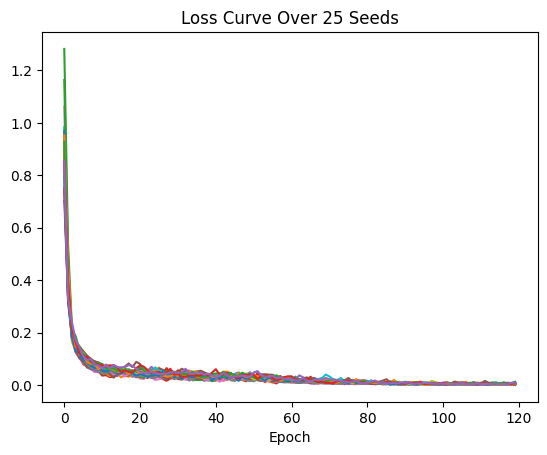

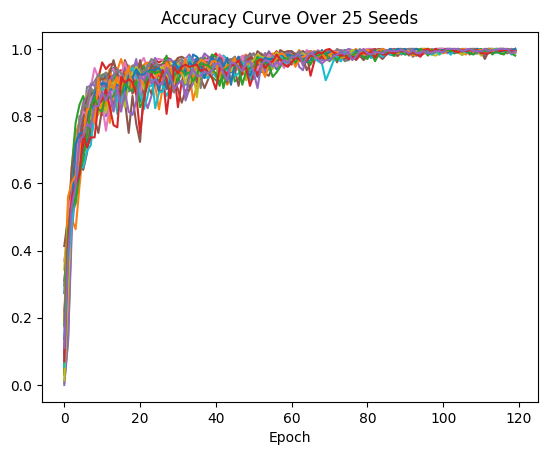

In [ ]:

with open('/content/drive/MyDrive/Results1/Train_Accuracy','rb') as f:
  x = pickle.load(f)

x1 = torch.stack(x)
#x2 = []
for i in range(25):
  x2 = x1[i*120:i*120+120]
  plt.plot(x2.detach().cpu())
  plt.title('Loss Curve Over 25 Seeds')
  plt.xlabel('Epoch')

with open('/content/drive/MyDrive/Results1/Train_loss','rb') as f:
  x12 =(pickle.load(f))

x22 = torch.tensor(x12)
#x2 = []
plt.figure()
for i in range(25):
  x2 = x22[i*120:i*120+120]
  plt.plot(x2.detach().cpu())
  plt.title('Accuracy Curve Over 25 Seeds')
  plt.xlabel('Epoch')
